
# Определение выгодного тарифа для телеком компании

**План проекта**

1. [Изучиение общей информации](#010)  
2. [Подготовка данных](#020)  
3. [Анализ данных](#030)  
4. [Проверка гипотез](#040)  
5. [Выводы](#050)  



**Данные**

В наличии имеестся 5 датасетов со следующими данными:

1) Таблица users (информация о пользователях):
   - уникальный идентификатор пользователя
   - имя пользователя
   - фамилия пользователя
   - возраст пользователя (годы)
   - дата подключения тарифа (день, месяц, год)
   - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
   - город проживания пользователя
   - название тарифного плана
   
2) Таблица calls (информация о звонках):
   - уникальный номер звонка
   - дата звонка
   - длительность звонка в минутах
   - идентификатор пользователя, сделавшего звонок

3) Таблица messages (информация о сообщениях):
   - уникальный номер сообщения
   - дата сообщения
   - идентификатор пользователя, отправившего сообщение

4) Таблица internet (информация об интернет-сессиях):
   - уникальный номер сессии
   - объём потраченного за сессию интернет-трафика (в мегабайтах)
   - дата интернет-сессии
   - идентификатор пользователя

5) Таблица tariffs (информация о тарифах):
   - название тарифа
   - ежемесячная абонентская плата в рублях
   - количество минут разговора в месяц, включённых в абонентскую плату
   - количество сообщений в месяц, включённых в абонентскую плату
   - объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
   - стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц,        то со 101 минуты будет взиматься плата)
   - стоимость отправки сообщения сверх тарифного пакета
   - стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# 1. Изучиение общей информации<a id='010'>

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
from math import factorial
import math
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.1f}'.format

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
    calls = pd.read_csv("calls.csv")
    calls.info()
    calls.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


id   call_date  duration  user_id
0  1000_0  2018-07-25       0.0     1000
1  1000_1  2018-08-17       0.0     1000
2  1000_2  2018-06-11       2.9     1000

Таблица содержит в себе архив звонков абонентов. Она содержит 202607  строки и 4 столбца. Всртечается 3 типа данных: целые числа (1 столбец), вещественные числа (1 столбец) и строки (2 столбца). Пропусков нет. В глаза бросается, что у некоторых звонков длительность равна 0.0 минут. Вероятно это появилось из-за того, что абонент пытался совершить исходящий вызов, он пошел и ситема его зафиксровала, но адресат звонка не взял трубку и протяженность зафиксировалась на уровне 0.0 мин. 

In [3]:
    internet = pd.read_csv("internet.csv")
    internet.info()
    internet.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0    113.0   2018-11-25     1000
1           1  1000_1  1,052.8   2018-09-07     1000
2           2  1000_2  1,197.3   2018-06-25     1000

Таблица содержит в себе архив интеренет-сессий абонентов. Она содержит 149396  строки и 4 столбца. Всртечается 3 типа данных: целые числа (1 столбец), вещественные числа (1 столбец) и строки (2 столбца). Пропусков нет.

In [4]:
    messages = pd.read_csv("messages.csv")
    messages.info()
    messages.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000

Таблица содержит в себе архив сообщений абонентов. Она содержит 123036  строки и 3 столбца. Всртечается 2 типа данных: целые числа (1 столбец), строки (2 столбца). Пропусков нет.

In [5]:
    tariffs = pd.read_csv("tariffs.csv")
    tariffs.info()
    tariffs.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

Таблица содержит в себе информацию о тарифах. Она содержит 2  строки и 8 столбца. Все данные имеют тип целые числа. Пропусков нет.

In [6]:
    users = pd.read_csv("users.csv")
    users.info()
    users.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   

  tariff  
0  ultra  
1  smart  
2  smart

Таблица содержит в себе архив абонентов. Она содержит 500 строк (данные о 500 абонентах) и 8 столбцов. Всртечается 2 типа данных: целые числа (2 столбца) и строки (6 столбцов). В глаза бросается наличие пропусков в столбце churn_date. Но здесь при дальнейщей обработке нужно помнить, что это дата прекращения пользования тарифом и если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

# 2. Подготовка данных<a id='020'>

В рамках подготовки данных нам нужно решить следующие задачи:
* Привести данные к нужным типам
* Найти и исправить ошибки в данных (Пояснить, какие ошибки нашли и как их исправили. Обратите внимание, что у 
  большого количества звонков длительность — 0.0 минут. Это проблема в данных, нужна предобработка)
* Посчитать для каждого пользователя:
 + количество сделанных звонков и израсходованных минут разговора по месяцам;
 + количество отправленных сообщений по месяцам;
 + объем израсходованного интернет-трафика по месяцам;
 + помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и  
   интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую  
   тарифному плану).


## Приведение данных к нужным типам и исправление ошибок

Создадим функцию для вывода типа данных в столбцах и первых строк таблицы

In [7]:
def type_coll(name_ds):
    name_ds.info()
    return name_ds.head(3)

### Обработаем таблицу calls

In [8]:
type_coll(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


id   call_date  duration  user_id
0  1000_0  2018-07-25       0.0     1000
1  1000_1  2018-08-17       0.0     1000
2  1000_2  2018-06-11       2.9     1000

В данной таблице необходимо поменять формат даты datatime, выделить столбец с месяцем (необходимо для дальнейших расчетов), убрать звонки с продолжительностью 0.0 (причина описывалась выше) и округлить минуты (приводя параллельно их к int) в соответсвии с правилами «Мегалайн», который всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Это необходимо сделать для корректных дальнейших подсчетов.

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')# переводим в dtTame

In [10]:
calls['month'] = calls['call_date'].dt.month_name() # добавляем столбец "month"

In [11]:
calls = calls.query('duration > 0').reset_index(drop=True) # убираем звонки продолжительностью 0.00

In [12]:
calls['duration'] = calls['duration'].apply(np.ceil).astype("int")# округляем минуты по правилам «Мегалайн»

In [13]:
calls['duration'].describe() # проверка замен и вообще расмотрение числового описания данных в столбце "duration"

count   162,994.0
mean          8.9
std           5.4
min           1.0
25%           5.0
50%           8.0
75%          12.0
max          38.0
Name: duration, dtype: float64

Замены прошли успешно данные в столбце duration адекватны

Проверим как прошли изменения

In [14]:
type_coll(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  int32         
 3   user_id    162994 non-null  int64         
 4   month      162994 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(2)
memory usage: 5.6+ MB


id  call_date  duration  user_id      month
0  1000_2 2018-06-11         3     1000       June
1  1000_3 2018-09-21        14     1000  September
2  1000_4 2018-12-15         6     1000   December

Видим, что таблица calls обработана корректно

### Обработаем таблицу internet

In [15]:
type_coll(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0    113.0   2018-11-25     1000
1           1  1000_1  1,052.8   2018-09-07     1000
2           2  1000_2  1,197.3   2018-06-25     1000

В данной таблице необходимо поменять формат даты datatime, выделить столбец с месяцем (необходимо для дальнейших расчетов), убрать сессии с продолжительностью 0.0 (причина аналогичная как для голосовых вызовов) и округлить трафик (приводя параллельно данные к int) в соответсвии с правилами «Мегалайн», который всегда округляет вверх значения минут и мегабайтов.

In [16]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')# переводим в dtTame

In [17]:
internet['month'] = internet['session_date'].dt.month_name() # добавляем столбец "month"

In [18]:
internet = internet.query('mb_used > 0').reset_index(drop=True) # убираем сессии продолжительностью 0.00

In [19]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype("int")# округляем трафик по правилам «Мегалайн»

Проверим как прошли изменения

In [20]:
internet['mb_used'].describe() # проверка замен и вообще расмотрение числового описания данных в столбце "duration"

count   129,798.0
mean        426.6
std         255.6
min           1.0
25%         228.0
50%         401.0
75%         593.0
max       1,725.0
Name: mb_used, dtype: float64

Замены прошли успешно данные в столбце mb_used адекватны

Проверим как прошли изменения

In [21]:
type_coll(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    129798 non-null  int64         
 1   id            129798 non-null  object        
 2   mb_used       129798 non-null  int32         
 3   session_date  129798 non-null  datetime64[ns]
 4   user_id       129798 non-null  int64         
 5   month         129798 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 5.4+ MB


Unnamed: 0      id  mb_used session_date  user_id      month
0           0  1000_0      113   2018-11-25     1000   November
1           1  1000_1     1053   2018-09-07     1000  September
2           2  1000_2     1198   2018-06-25     1000       June

Видим, что таблица internet обработана корректно

### Обработаем таблицу messages

In [22]:
type_coll(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000

В данной таблице необходимо поменять формат даты datatime и выделить столбец с месяцем (необходимо для дальнейших расчетов).

In [23]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')# переводим в dtTame

In [24]:
messages['month'] = messages['message_date'].dt.month_name() # добавляем столбец "month"

Проверим как прошли изменения

In [25]:
type_coll(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.8+ MB


id message_date  user_id    month
0  1000_0   2018-06-27     1000     June
1  1000_1   2018-10-08     1000  October
2  1000_2   2018-08-04     1000   August

Видим, что таблица messages обработана корректно

### Обработаем таблицу tariffs

In [26]:
type_coll(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

В таблице tariffs все корректно, измеения не пребуются

### Обработаем таблицу users

In [27]:
type_coll(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   

  tariff  
0  ultra  
1  smart  
2  smart

В данной таблице необходимо поменять формат даты datatime в двух столбцах, и заменить пропуски в churn_date на 0, для удобства дальнейщих расчетов. А также посмотрим дубликаты по user_id

In [28]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')# переводим в dtTame

In [29]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')# переводим в dtTame

In [30]:
users['churn_date'] = users['churn_date'].fillna(value = 0) # заменяем NaT на 0

Проверим как прошли изменения

In [31]:
type_coll(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


user_id  age churn_date         city first_name  last_name   reg_date  \
0     1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
1     1001   41          0       Москва       Иван       Ежов 2018-11-01   
2     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   

  tariff  
0  ultra  
1  smart  
2  smart

Видим, что таблица users обработана корректно

Посмотрим дубликаты

In [32]:
users['user_id'].duplicated().sum()

0

Видим, что дубликатов нет. Все user_id уникальны

### Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

Для поиска данных параметров воспользуемся сводной таблицей

In [33]:
calls_count_duration_sum = calls.pivot_table(index = ['user_id', 'month'], values = ['id', 'duration'],
                       aggfunc = {'id':'count', 'duration':'sum'})

Заменим названия столбцов

In [34]:
calls_count_duration_sum.columns = ['duration_sum', 'calls_count']

In [35]:
calls_count_duration_sum.head(15) # посмотрим, что полчилось

duration_sum  calls_count
user_id month                               
1000    August              408           42
        December            333           38
        July                340           41
        June                172           28
        May                 159           17
        November            338           37
        October             350           44
        September           466           46
1001    December            414           47
        November            430           45
1002    August              289           37
        December            236           27
        July                214           21
        June                117           14
        November            243           25

Все Ок!

### Подсчет количества  отправленных сообщений по месяцам для каждого пользователя¶

Для поиска данного параметра воспользуемся сводной таблицей

In [36]:
messages_count = messages.pivot_table(index = ['user_id', 'month'], values = ['id'],
                       aggfunc = {'id':'count'})

Заменим названия столбцов

In [37]:
messages_count.columns = ['messages_count']

In [38]:
messages_count.head(15) # посмотрим, что полчилось

messages_count
user_id month                    
1000    August                 81
        December               70
        July                   75
        June                   60
        May                    22
        November               58
        October                73
        September              57
1002    August                 13
        December               12
        July                   11
        June                    4
        November               16
        October                10
        September               4

### Подсчет количества  отправленных сообщений по месяцам для каждого пользователя¶

Для поиска данных параметров воспользуемся сводной таблицей

In [39]:
messages

id message_date  user_id      month
0         1000_0   2018-06-27     1000       June
1         1000_1   2018-10-08     1000    October
2         1000_2   2018-08-04     1000     August
3         1000_3   2018-06-16     1000       June
4         1000_4   2018-12-05     1000   December
...          ...          ...      ...        ...
123031  1499_179   2018-12-12     1499   December
123032  1499_180   2018-09-28     1499  September
123033  1499_181   2018-09-27     1499  September
123034  1499_182   2018-11-15     1499   November
123035  1499_183   2018-11-16     1499   November

[123036 rows x 4 columns]

In [40]:
messages_count = messages.pivot_table(index = ['user_id', 'month'], values = ['id'],
                       aggfunc = {'id':'count'})

Заменим названия столбцов

In [41]:
messages_count.columns = ['messages_count']

In [42]:
messages_count.head(15) # посмотрим, что полчилось

messages_count
user_id month                    
1000    August                 81
        December               70
        July                   75
        June                   60
        May                    22
        November               58
        October                73
        September              57
1002    August                 13
        December               12
        July                   11
        June                    4
        November               16
        October                10
        September               4

Все Ок!

### Подсчет  объема израсходованного интернет-трафика по месяцам для каждого пользователя¶

Для поиска данных параметров воспользуемся сводной таблицей

In [43]:
internet_count = internet.pivot_table(index = ['user_id', 'month'], values = ['mb_used'],
                       aggfunc = {'mb_used':'sum'})

Заменим названия столбцов

In [44]:
internet_count.columns = ['internet_count']

In [45]:
internet_count.head(15) # посмотрим, что полчилось

internet_count
user_id month                    
1000    August              14070
        December             9827
        July                14016
        June                23257
        May                  2256
        November            14768
        October             14717
        September           14581
1001    December            14053
        November            18452
1002    August              20347
        December            18137
        July                17601
        June                10871
        November            18610

Все Ок!

### Подсчет помесячной выручки с каждого пользователя

Прежде чем посчитать выручку с каждого пользователя необходимо объединить последние три таблицы

In [46]:
users_calls_messages = calls_count_duration_sum.merge(messages_count, on=['user_id', 'month'], how='outer').sort_values(by = "user_id", ascending=True)
      # объединение calls_count_duration_sum и messages_count 

Проверим, что получилось

In [47]:
users_calls_messages.head()

duration_sum  calls_count  messages_count
user_id month                                              
1000    August           408.0         42.0            81.0
        December         333.0         38.0            70.0
        July             340.0         41.0            75.0
        June             172.0         28.0            60.0
        May              159.0         17.0            22.0

Все Ок!

In [48]:
users_calls_messages_internet = users_calls_messages.merge(internet_count, on=['user_id', 'month'], how='outer').sort_values(by = "user_id", ascending=True).reset_index()
   #  объединение users_calls_messages и internet_count 

Проверим, что получилось

In [49]:
users_calls_messages_internet.head()

user_id     month  duration_sum  calls_count  messages_count  \
0     1000    August         408.0         42.0            81.0   
1     1000  December         333.0         38.0            70.0   
2     1000      July         340.0         41.0            75.0   
3     1000      June         172.0         28.0            60.0   
4     1000       May         159.0         17.0            22.0   

   internet_count  
0        14,070.0  
1         9,827.0  
2        14,016.0  
3        23,257.0  
4         2,256.0

Все Ок!

И наконец объединим users и users_calls_messages_internet

In [50]:
users_general = users.merge(users_calls_messages_internet, on=['user_id'], how='outer').sort_values(by = "user_id", ascending=True)
   #  объединение users и users_calls_messages_internet 

Проверим, что получилось

In [51]:
users_general.head(30)

user_id  age churn_date         city first_name  last_name   reg_date  \
0      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
1      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
2      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
3      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
4      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
5      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
6      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
7      1000   52          0    Краснодар     Рафаил  Верещагин 2018-05-25   
8      1001   41          0       Москва       Иван       Ежов 2018-11-01   
9      1001   41          0       Москва       Иван       Ежов 2018-11-01   
16     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
15     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
14     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
12     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
11     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
10     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
13     1002   59          0  Стерлитамак    Евгений  Абрамович 2018-06-17   
17     1003   23          0       Москва      Белла   Белякова 2018-08-17   
18     1003   23          0       Москва      Белла   Белякова 2018-08-17   
19     1003   23          0       Москва      Белла   Белякова 2018-08-17   
20     1003   23          0       Москва      Белла   Белякова 2018-08-17   
21     1003   23          0       Москва      Белла   Белякова 2018-08-17   
27     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
29     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
28     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
26     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
23     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
24     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
22     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
25     1004   68          0  Новокузнецк    Татьяна   Авдеенко 2018-05-14   

   tariff      month  duration_sum  calls_count  messages_count  \
0   ultra     August         408.0         42.0            81.0   
1   ultra   December         333.0         38.0            70.0   
2   ultra       July         340.0         41.0            75.0   
3   ultra       June         172.0         28.0            60.0   
4   ultra        May         159.0         17.0            22.0   
5   ultra   November         338.0         37.0            58.0   
6   ultra    October         350.0         44.0            73.0   
7   ultra  September         466.0         46.0            57.0   
8   smart   November         430.0         45.0             nan   
9   smart   December         414.0         47.0             nan   
16  smart       June         117.0         14.0             4.0   
15  smart     August         289.0         37.0            13.0   
14  smart   December         236.0         27.0            12.0   
12  smart   November         243.0         25.0            16.0   
11  smart    October         212.0         24.0            10.0   
10  smart  September         206.0         25.0             4.0   
13  smart       July         214.0         21.0            11.0   
17  ultra  September         961.0        105.0            91.0   
18  ultra    October         855.0         97.0            83.0   
19  ultra     August         380.0         43.0            37.0   
20  ultra   December         802.0         88.0            75.0   
21  ultra   November         824.0         95.0            94.0   
27  ultra       July         135.0         20.0           181.0   
29  ultr

Все Ок!

In [52]:
users_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   age             3216 non-null   int64         
 2   churn_date      3216 non-null   object        
 3   city            3216 non-null   object        
 4   first_name      3216 non-null   object        
 5   last_name       3216 non-null   object        
 6   reg_date        3216 non-null   datetime64[ns]
 7   tariff          3216 non-null   object        
 8   month           3214 non-null   object        
 9   duration_sum    3168 non-null   float64       
 10  calls_count     3168 non-null   float64       
 11  messages_count  2717 non-null   float64       
 12  internet_count  3201 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 351.8+ KB


### Расчет помесячной выручки с каждого пользователя

Рассчитаем помесячную выручку отдельно для каждого тарифа для каждого пользователя для каждого месяца

Напишем функцию, которая будет возвращать выручку для тарифа smart

In [53]:
def revenue_smart(users_general_row):
    users_general_revenue = 0
    if (users_general_row["duration_sum"]  - 500) > 0:
        users_general_revenue = (users_general_row["duration_sum"]  - 500) * 3
    if (users_general_row["messages_count"]  - 50) > 0:
        users_general_revenue = users_general_revenue + ((users_general_row["messages_count"]  - 50) * 3)
    if (users_general_row["internet_count"]  - 15000) > 0:
        users_general_revenue = users_general_revenue + (math.ceil((users_general_row["internet_count"]  - 15000)/1000) * 200)
    users_general_revenue = users_general_revenue + 550
    return users_general_revenue

Создадим столбец revenue_smart в который будут возвращены выручки, посчитанные применением функции для пользователей тарифа smart и обнулим выручку для пользователей тарифа ultra для удобства дальнейшей работы

In [54]:
users_general['revenue_smart'] = users_general[users_general["tariff"] == "smart"].apply(revenue_smart, axis=1)
users_general['revenue_smart'] = users_general['revenue_smart'].fillna(0)

Напишем функцию, которая будет возвращать выручку для тарифа ultra

In [55]:
def revenue_ultra(users_general_row):
        users_general_revenue = 0
        if (users_general_row["duration_sum"]  - 3000) > 0:
            users_general_revenue = (users_general_row["duration_sum"]  - 3000) * 1
        if (users_general_row["messages_count"]  - 1000) > 0:
            users_general_revenue = users_general_revenue + ((users_general_row["messages_count"]  - 1000) * 1)
        if (users_general_row["internet_count"]  - 30000) > 0:
            users_general_revenue = users_general_revenue + (math.ceil((users_general_row["internet_count"]  - 30000)/1000) * 150)
        users_general_revenue = users_general_revenue + 1950
        return users_general_revenue

Создадим столбец revenue_ultra в который будут возвращены выручки, посчитанные применением функции для пользователей тарифа ultra и обнулим выручку для пользователей тарифа smart для удобства дальнейшей работы

In [56]:
users_general['revenue_ultra'] = users_general[users_general["tariff"] == "ultra"].apply(revenue_ultra, axis=1)
users_general['revenue_ultra'] = users_general['revenue_ultra'].fillna(0)

Объединим выручку из разных тарифов в один столбец revenue и удалим столбцы 'revenue_smart' и "revenue_ultra"

In [57]:
users_general['revenue'] = users_general['revenue_ultra'] + users_general['revenue_smart']

In [58]:
users_general = users_general.drop(['revenue_smart', "revenue_ultra"], axis=1)

Проверим, что получилось

In [59]:
users_general

user_id  age           churn_date         city first_name  last_name  \
0        1000   52                    0    Краснодар     Рафаил  Верещагин   
1        1000   52                    0    Краснодар     Рафаил  Верещагин   
2        1000   52                    0    Краснодар     Рафаил  Верещагин   
3        1000   52                    0    Краснодар     Рафаил  Верещагин   
4        1000   52                    0    Краснодар     Рафаил  Верещагин   
...       ...  ...                  ...          ...        ...        ...   
3211     1498   68  2018-10-25 00:00:00  Владикавказ   Всеволод    Акимчин   
3214     1499   35                    0        Пермь     Гектор   Корнилов   
3212     1499   35                    0        Пермь     Гектор   Корнилов   
3213     1499   35                    0        Пермь     Гектор   Корнилов   
3215     1499   35                    0        Пермь     Гектор   Корнилов   

       reg_date tariff      month  duration_sum  calls_count  messages_count  \
0    2018-05-25  ultra     August         408.0         42.0            81.0   
1    2018-05-25  ultra   December         333.0         38.0            70.0   
2    2018-05-25  ultra       July         340.0         41.0            75.0   
3    2018-05-25  ultra       June         172.0         28.0            60.0   
4    2018-05-25  ultra        May         159.0         17.0            22.0   
...         ...    ...        ...           ...          ...             ...   
3211 2018-07-19  smart  September         471.0         53.0            44.0   
3214 2018-09-27  smart   November         612.0         62.0            59.0   
3212 2018-09-27  smart  September          70.0          8.0            11.0   
3213 2018-09-27  smart    October         449.0         44.0            48.0   
3215 2018-09-27  smart   December         492.0         56.0            66.0   

      internet_count  revenue  
0           14,070.0  1,950.0  
1            9,827.0  1,950.0  
2           14,016.0  1,950.0  
3           23,257.0  1,950.0  
4            2,256.0  1,950.0  
...              ...      ...  
3211        22,166.0  2,150.0  
3214        17,984.0  1,513.0  
3212         1,848.0    550.0  
3213        17,809.0  1,150.0  
3215        13,077.0    598.0  

[3216 rows x 14 columns]

Все Ок!

# 3. Анализ данных<a id='030'>

## Анализ количества минут разговора, которое требуется пользователям каждого тарифа в месяц

Напишем функцию для определения показателей и построения гистограмм. Учтитывая, что мы оцениваем дискретные, кратные единице, нам нужно строить гистограмму частот.

In [60]:
def statistics(collumn_indicator):
    mu_u = users_general.query('tariff == "ultra"')[collumn_indicator].mean()
    variance_estimate_u = np.var(users_general.query('tariff == "ultra"')[collumn_indicator], ddof=1)
    standard_deviation_u = np.std(users_general.query('tariff == "ultra"')[collumn_indicator], ddof=1)
    print("Показатели по тарифу ultra")
    print("mu", mu_u)
    print("variance_estimate", variance_estimate_u)
    print("standard_deviation", standard_deviation_u)
    print()
    mu_s = users_general.query('tariff == "smart"')[collumn_indicator].mean()
    variance_estimate_s = np.var(users_general.query('tariff == "smart"')[collumn_indicator], ddof=1)
    standard_deviation_s = np.std(users_general.query('tariff == "smart"')[collumn_indicator], ddof=1)
    print("Показатели по тарифу smart")
    print("mu", mu_s)
    print("variance_estimate", variance_estimate_s)
    print("standard_deviation", standard_deviation_s)
    
    print(users_general.query('tariff == "ultra"')[collumn_indicator].hist(bins=20, alpha=0.5, label='ultra'))
    print(users_general.query('tariff == "smart"')[collumn_indicator].hist(bins=20, alpha=0.5, label='smart'))
    plt.legend()

    #print(users_general.boxplot([collumn_indicator], rot=45, fontsize=15, figsize=(10, 15)))

### Количество минут

Определим среднее значение, дисперсию и стандартное отклонение минут для тарифов

Показатели по тарифу ultra
mu 547.7550158394931
variance_estimate 93338.4282914109
standard_deviation 305.513384799113

Показатели по тарифу smart
mu 419.4403421882035
variance_estimate 35718.128533936935
standard_deviation 188.9924033762652
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


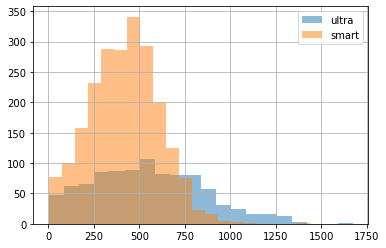

In [61]:
statistics("duration_sum")

Описание распределений: Распределения количества минут в обоих тарифах имеют вид нормального распределения со сдвигом вправо. Но есть свои особености. В тарифе Смарт большая часть пользователей разговаривает менее 550 минут, статаясь уложиться в абоненткий пакет и выручка сверх абонентской платы в целом не велика. На тарифе Ультра все пользователи уклаываются до 1750 минут и не истрачивают свой пакет в 3000 минут, и, следовательно обходятся бюджетом в части разговоров в 1950 рублей абонентской платы.

### Количество сообщений

Определим среднее значение, дисперсию и стандартное отклонение количесва сообщений для тарифов

Показатели по тарифу ultra
mu 61.161006289308176
variance_estimate 2109.659182865204
standard_deviation 45.931026364160466

Показатели по тарифу smart
mu 38.71644120707596
variance_estimate 717.5942011753527
standard_deviation 26.787948804926305
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


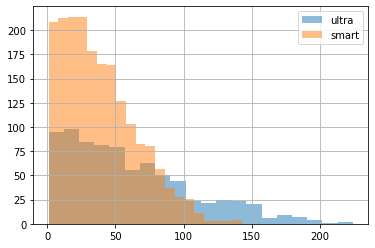

In [62]:
statistics("messages_count")

Описание распределений: Распределения количества сообщений в обоих тарифах имеют вид распределения Пуассона. Это связано с тем, что большая часть пользователей  не отправляет смс. В тарифе Смарт большая часть пользователей отправляет менее 50 сообщений, статаясь уложиться в абоненткий пакет и выручка сверх абонентской платы в целом не велика. На тарифе Ультра все пользователи уклаываются до 250 смс и не истрачивают свой пакет в 1000 смс, и, следовательно обходятся бюджетом в части разговоров в 1950 рублей абонентской платы.

### Объем интернет-трафика

Определим среднее значение, дисперсию и стандартное отклонение объема интернет-трафика для тарифов

Показатели по тарифу ultra
mu 19706.979466119097
variance_estimate 98746498.9327742
standard_deviation 9937.127297804644

Показатели по тарифу smart
mu 16243.763358778626
variance_estimate 34340091.55358953
standard_deviation 5860.041941282462
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


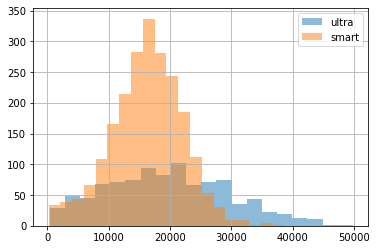

In [63]:
statistics("internet_count")

Описание распределений: Распределения количества минут в обоих тарифах имеют вид нормального распределения практически без сдвига. В тарифе Смарт больше половина пользователей расходует более 15 Гб и не укладывается в абоненткий пакет, обеспечивая хорошую выручку. На тарифе Ультра большая часть пользователи уклаываются до 30 Гб и не истрачивают свой пакет в 3000 минут, и, следовательно обходятся бюджетом в части разговоров в 1950 рублей абонентской платы. Но есть также достаточно большая группа пользователей, которые не укладываются в 30 Гб и доплачивают сверх 1950 рублей абонентской платы.

# 4. Проверка гипотез<a id='040'>

Проверим две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


## Проверка гипотезы, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Данная гипотеза отностся к типичной гипотезе:
* средние двух генеральных совокупностей равны между собой

Таким образом имеем:
* Нулевую гипотезу -  средние выручки пользователей тарифов «Ультра» и «Смарт» равны
* Альтернативную гипотезу - средние выручки пользователей тарифов «Ультра» и «Смарт» не равны

Проверим эту нулевую гипотезу. Возмем alpha = 0.05, по 2,5% с каждой стороны нам вполне хватит. equal_var = True, поскольку выборки схожи и дисперсии выборок не сильно отличаются.

In [64]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(users_general.query('tariff == "ultra"')["revenue"], users_general.query('tariff == "smart"')["revenue"])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 7.798534648122286e-134
Отвергаем нулевую гипотезу


Таким образом мы обнаружили слишком маленькую вероятность, что различие средних выручек может быть случайным. Эта слишком маленькая вероятность позволяет нам делать вывод о значимом различии между выручками. Т.е. мы будем придерживаться альтернативной гипотезы, о том, что средние выручки пользователей тарифов «Ультра» и «Смарт» не равны. 

Но нужно помнить, что данные могут лишь не противоречить гипотезе или, наоборот, показывать крайне маловероятные результаты. Но и в том, и в другом случае нет оснований утверждать, что выдвинутая гипотеза доказана.

## Проверка гипотезы, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Данная гипотеза отностся к типичной гипотезе:
* средние двух генеральных совокупностей равны между собой

Таким образом имеем:
* Нулевую гипотезу -  средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов равны
* Альтернативную гипотезу - средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов не равны

Проверим эту нулевую гипотезу. Возмем alpha = 0.05, по 2,5% с каждой стороны нам вполне хватит.

In [65]:
alpha = 0.05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(users_general.query('city == "Москва"')["revenue"], users_general.query('city != "Москва"')["revenue"])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.5933795316207562
Не получилось отвергнуть нулевую гипотезу


Таким образом мы обнаружили вероятность почти 60%, что различие средних выручек может быть случайным. Такая большая вероятность позволяет нам делать вывод об отсутсвии значимого различии между выручками. Т.е. мы будем придерживаться нулевой гипотезы, о том, что средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов равны. 

# 5. Выводы<a id='050'>

Относительно прибыльности тарифов мы отвергли нулевую гипотезу и продолжаем придерживаться альтернативной гипотезы, о том, что средние выручки пользователей тарифов «Ультра» и «Смарт» не равны. Посмотрим в чем же их отличие.

In [66]:
print(users_general.query('tariff == "ultra"')["revenue"].describe())
print(users_general.query('tariff == "ultra"')["revenue"].sum())

count     986.0
mean    2,090.6
std       415.9
min     1,950.0
25%     1,950.0
50%     1,950.0
75%     1,950.0
max     4,950.0
Name: revenue, dtype: float64
2061300.0


In [67]:
print(users_general.query('tariff == "smart"')["revenue"].describe())
print(users_general.query('tariff == "smart"')["revenue"].sum())

count   2,230.0
mean    1,349.8
std       857.0
min       550.0
25%       568.0
50%     1,150.0
75%     1,859.8
max     6,970.0
Name: revenue, dtype: float64
3010101.0


### Выводы: 
1. Средняя выручка с тарифа ultra статистически значимо в среднем выше выручки с тарифа smart на 55%.
2. Средняя выручка от пользователей в Москве и других городах статистически значимо в среднем равны
3. Значительную долю в структуре выручки на тарифе smart занимают платежи сверх абонентской платы
4. Большей части клиентов тарифа ultra хватает базового пакета услуг и они не тратят деньги на приобретения дополнительных пакетов (звонков, смс или интернета) в течении месяца 
5. Общая выручка с тарифа smart выше выручки с тарифа ultra на 50%